# LSC Notebook

## LSC studies

In [87]:
import time

In [1]:
from __future__ import print_function

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import MPLibFunctions as mpl
import PDFunctions as pdf
from Util import *
import FEParam as FP
from scipy import signal as SGN

In [32]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [88]:
print(time.strftime("%d/%m/%Y"))
print(time.strftime("%H:%M:%S"))

22/09/2016
17:28:55


### First study of pulses at the LSC with hdf5

1. hdf5 files generated with current version of writer still show problems
2. generated pulses are too short. 

In [6]:
%ls ../../../data/LSC/

pulseVar_r2033.h5*  pulseVar_r2058.h5*


In [7]:
h5f =tb.open_file('../../../data/LSC/pulseVar_r2058.h5')

In [8]:
h5f

File(filename=../../../data/LSC/pulseVar_r2058.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(2, 6, 48000), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(2, 1215, 1200), zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 1200)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/Sensors (Group) ''
/Sensors/DataPMT (Table(6,)) ''
  description := {
  "channel": Int32Col(shape=(), dflt=0, pos=0),
  "

In [9]:
pmtrwf = h5f.root.pmtrd

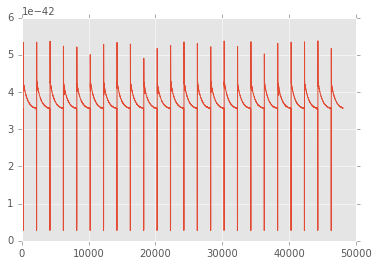

In [10]:
plt.plot(pmtrwf[0,0])

#### Issues

1. Scale is wrong
2. Only 6 PMTs written
3. PMTRD field is not correct. Must be PMTRWF (in folder RD)

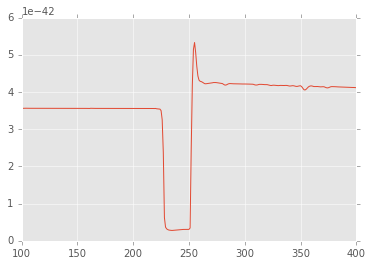

In [15]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([100, 400])
plt.plot(pmtrwf[0,0])

In [38]:
pmt0 = pmtrwf[0,0]*1e+44*(-1)

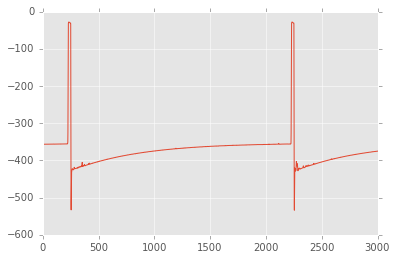

In [39]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([0, 3000])
plt.plot(pmt0)

In [40]:
signal_daq = pmt0[0:2000]

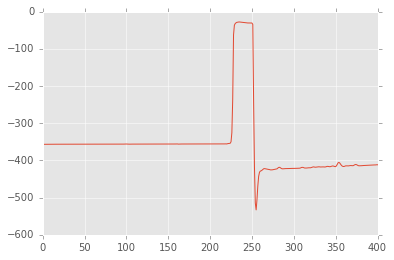

In [42]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([0, 400])
plt.plot(signal_daq)

###  Deconv function

In [31]:
class SBLR:
    """
    Signals BLR: a simple class to hold of the signals relevant for BLR
    """
    def __init__(self, len_signal_daq):
        """
        len_signal_daq: length of the signal to deconvolute
        
        
        """
        
        self.MAU = np.zeros(len_signal_daq, dtype=np.double)
        self.acum = np.zeros(len_signal_daq, dtype=np.double)
        self.signal_r = np.zeros(len_signal_daq, dtype=np.double)
        self.pulse_on = np.zeros(len_signal_daq, dtype=np.double)
        self.wait_over = np.zeros(len_signal_daq, dtype=np.double)
        self.offset = np.zeros(len_signal_daq, dtype=np.double)
        self.BASELINE = 0
        

def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = FP.NOISE_ADC, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
    
    logging.debug("sblr.signal_r[0:10]= {}".format(sblr.signal_r[0:10]))
    logging.debug("BASELINE ={}".format(sblr.BASELINE))
                       
    sblr.signal_r = sblr.signal_r - sblr.BASELINE
    
    logging.debug("sblr.signal_r[0:10] - BASELINE= {}".format(sblr.signal_r[0:10]))
   
    return  sblr

def accumulator_coefficients(pmtrd,CA):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    coef_acc =np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef_acc[j] = signal_inv_daq[10] #any index is valid, function is flat
        
    return coef_acc

def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=FP.NOISE_ADC, thr3 = FP.NOISE_ADC, log='INFO'):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """
    
    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    
    BLRS =[]
    for j in range(NPMT):
        sblr = BLR(pmtrd[event_number, j], coeff_acc[j], mau_len, thr1, thr2, thr3, log)
        BLRS.append(sblr)
       
    return BLRS



In [33]:
acc = 0.0016414818563650

In [43]:
sblr = BLR(signal_daq, acc, 200, 3., 0., 1., 'DEBUG')

DEBUG:root:-->BLR: 
                     MAU_LEN=200
                     thr1 = 3.0, thr2 = 0.0, thr3 = 1.0 =
DEBUG:root:n = 200, acum[n] = 0.0 BASELINE =-356.236694302
DEBUG:root:nm = 200
DEBUG:root:sblr.signal_r[0:10]= [-356.77058902 -356.77058902 -356.91071886 -357.05084871 -356.63045917
 -356.63045917 -356.77058902 -356.63045917 -356.63045917 -356.63045917]
DEBUG:root:BASELINE =-356.236694302
DEBUG:root:sblr.signal_r[0:10] - BASELINE= [-0.53389471 -0.53389471 -0.67402456 -0.81415441 -0.39376487 -0.39376487
 -0.53389471 -0.39376487 -0.39376487 -0.39376487]


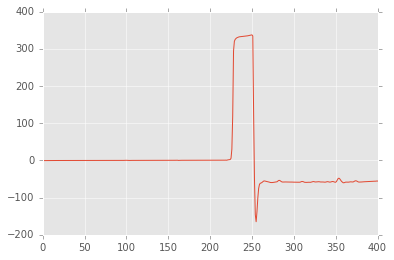

In [44]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([0, 400])
plt.plot(sblr.signal_r)

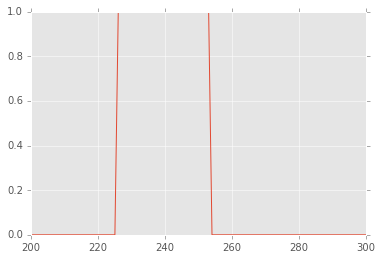

In [71]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([200, 300])
plt.plot(sblr.pulse_on)

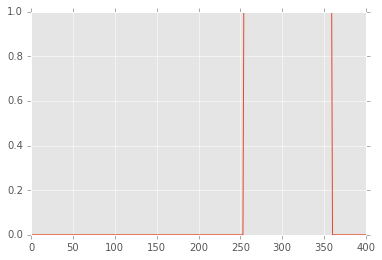

In [47]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([0, 400])
plt.plot(sblr.wait_over)

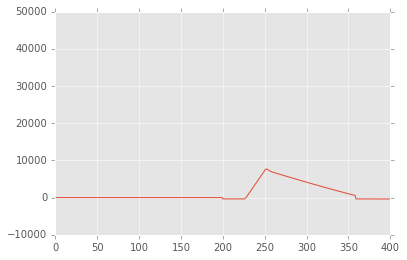

In [48]:
ax1 = plt.subplot(1,1,1)
ax1.set_xlim([0, 400])
plt.plot(sblr.acum)

Signal is too narrow and can't be deconvoluted.

In [61]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.values >threshold]

In [79]:
type(sblr.pulse_on)

numpy.ndarray

In [80]:
pon = sblr.pulse_on[0:400]

In [81]:
spon = pd.Series(pon)

In [84]:
pulse_on = wf_thr(pd.Series(sblr.pulse_on[0:400]),threshold=0.5)

In [86]:
len(pulse_on)*25./1000.

0.7

#### Issues

1. Pulse is too short. Deconvolution does not work properly in very short pulses. 

### Actions

1. JMB and PN to fix writer. Three issues: a) field (pmtrwf no pmtrd), b) number of PMTs, c) waveform scale.

2. AL to try and generate wider pulses.

3. VH to review this notebook and confirm agrees with analysis (pulses too short).